In [1]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("png")

from data import mat_utils, plots
from data.dataset import Dataset1, Dataset4
from models import classifier, crossval, evaluation, feature_extractor
from models.model import Model

rseed = 42

In [2]:
!ls ~/data/BCI

1_EEG_LRhandMI  4_EEG_6StatesMI


# Dataset 1: Left/Right Hand MI
Includes 52 subjects (38 validated subjects with discriminative features), results of physiological and psychological questionnares, EMG Datasets, location of 3D EEG electrodes, and EEGs for non-task related states.

### DS1 File Contents

In [3]:
DATASET1_PATH = os.path.expanduser('~/data/BCI/1_EEG_LRhandMI')
print(DATASET1_PATH)
print(os.listdir(DATASET1_PATH)[:5])

/Users/anna/data/BCI/1_EEG_LRhandMI
['s01.mat', 's15.mat', 's29.mat', 's28.mat', 's14.mat']


In [4]:
subject1_path = os.path.join(DATASET1_PATH, 's38.mat')
mat_utils.print_top_level_keys(subject1_path)

['eeg']


In [5]:
mat_utils.print_key_info(subject1_path, 'eeg')

`eeg` keys: ['noise', 'rest', 'srate', 'movement_left', 'movement_right', 'movement_event', 'n_movement_trials', 'imagery_left', 'imagery_right', 'n_imagery_trials', 'frame', 'imagery_event', 'comment', 'subject', 'bad_trial_indices', 'psenloc', 'senloc']
noise                ndarray         shape=(5,) dtype=object
rest                 ndarray         shape=(68, 34048) dtype=float32
srate                int             value=512
movement_left        ndarray         shape=(68, 71680) dtype=float32
movement_right       ndarray         shape=(68, 71680) dtype=float32
movement_event       ndarray         shape=(71680,) dtype=uint8
n_movement_trials    int             value=20
imagery_left         ndarray         shape=(68, 358400) dtype=float32
imagery_right        ndarray         shape=(68, 358400) dtype=float32
n_imagery_trials     int             value=100
frame                ndarray         shape=(2,) dtype=int16
imagery_event        ndarray         shape=(358400,) dtype=uint8
comment

In [6]:
ds1 = Dataset1(
    dataset_path=DATASET1_PATH,
    exclude_subject_ids=['29', '34'],
    preprocess_highpass=True,
    preprocess_car=True,
    preprocess_band=True
)
ds1.print_info()

Total subjects: 50
Epoch window: 0.500–2.500 s
Total subject data: 2530.00 MB


In [7]:
ds1_subject38 = ds1.get_subject(38)
ds1_subject38.print_info()

Subject ID: 38
sampling_rate: 512, n_trials: 200, n_channels: 64, n_samples: 1024
X: (200, 64, 1024), Y: (200,)


### DS1 Data Examples

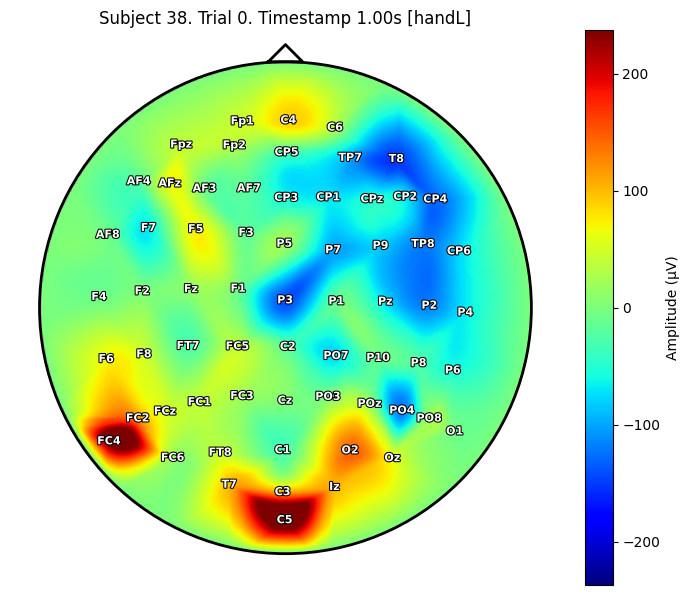

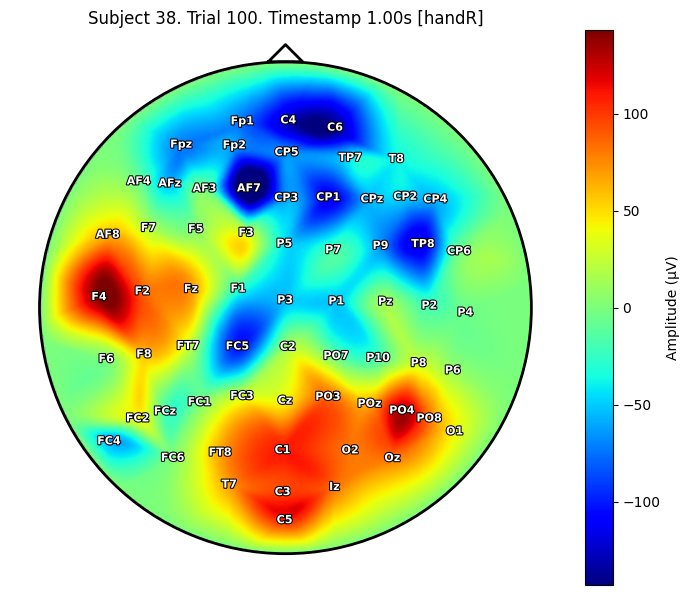

In [9]:
ds1_subject38.plot_head(trial=0, timestamp=1.0, plot_joint=True)

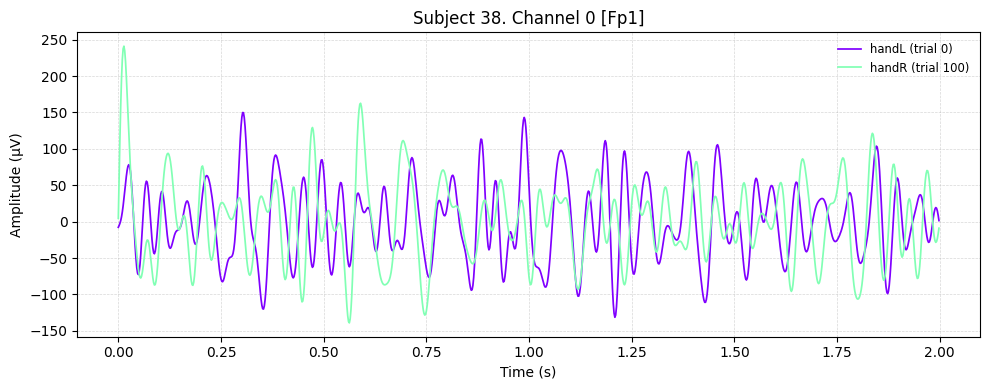

In [9]:
ds1_subject38.plot_channel(trial=0, channel=0)

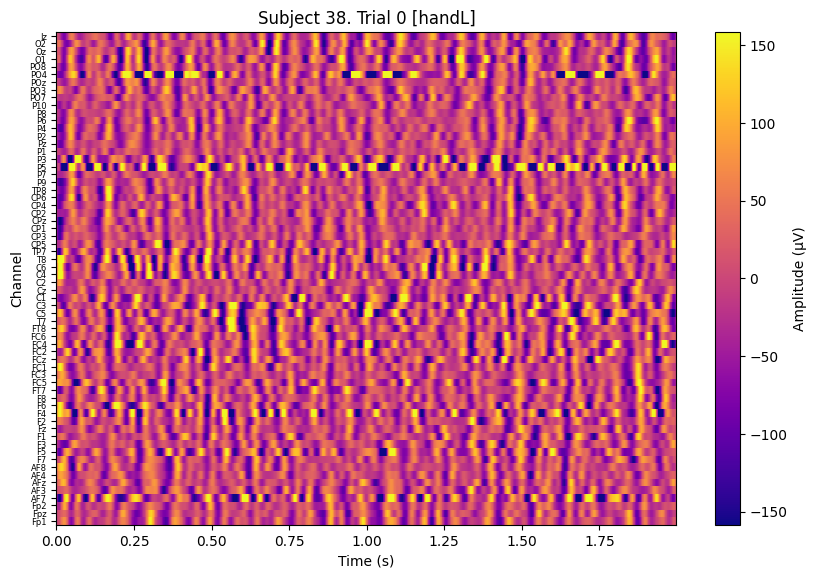

In [10]:
ds1_subject38.plot_trial_heatmap(trial=0)

## DS1 Classification

In [8]:
ds1X, ds1Y, ds1groups = ds1.get_XY()
ds1X.shape, ds1Y.shape, ds1groups.shape

((10120, 64, 1024), (10120,), (10120,))

### Paper Baseline

In [9]:
ds1_baseline_model = Model(
    feat=feature_extractor.CSPLogVar(n_components=4, reg=1e-10),
    clf=classifier.LDAClassifier(shrinkage=False)
)
ds1_crossval = crossval.RepeatedSubsetCrossval(n_subsets=10, test_k=3, n_repeats=120, seed=rseed)

In [10]:
scores = ds1_crossval.eval_all_subjects(model=ds1_baseline_model, X=ds1X, y=ds1Y, groups=ds1groups)

In [12]:
summary = evaluation.summarize_subject_means([r.mean for r in scores.values()])
summary

{'n_subjects': 50,
 'mean': 0.6771259259259259,
 'std': 0.12897305575893353,
 'sem': 0.01823954446349852,
 'ci95_half': 0.0357495071484571}

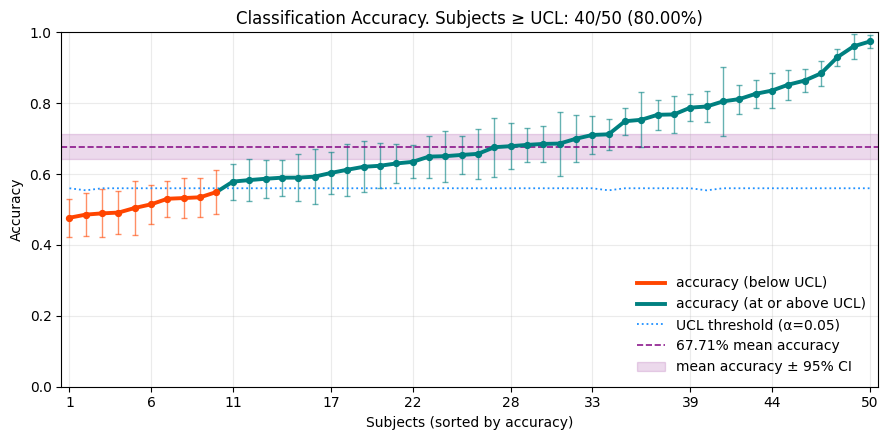

In [13]:
plots.plot_subject_accuracies(
    scores=scores,
    summary=summary,
    show_mean_line=True,
    show_ci_band=True
)

### Ablation Study

In [ ]:
ablation_results = {}
for preprocess_highpass in (True, False):
    for preprocess_car in (True, False):
        for preprocess_band in (True, False):
            ds1_test = Dataset1(
                dataset_path=DATASET1_PATH,
                exclude_subject_ids=['29', '34'],
                preprocess_highpass=preprocess_highpass,
                preprocess_car=preprocess_car,
                preprocess_band=preprocess_band
            )
            ds1_test_X, ds1_test_Y, ds1_test_groups = ds1_test.get_XY()
            ds1_baseline_test = ds1_baseline.CSP_LDA(n_components=4, reg=1e-10)
            ds1_crossval_test = ds1_baseline.RepeatedSubsetCrossval(n_subsets=10, test_k=3, n_repeats=120, seed=rseed)
            test_scores = ds1_crossval_test.eval_all_subjects(model=ds1_baseline_test, X=ds1_test_X, y=ds1_test_Y, groups=ds1_test_groups)
            ablation_results[(preprocess_highpass, preprocess_car, preprocess_band)] = test_scores

In [ ]:
for settings, ablation_scores in ablation_results.items():
    summary = evaluation.summarize_subject_means([r.mean for r in ablation_scores.values()])
    print(settings, summary['mean'])

(True, True, True) 0.6771259259259259
(True, True, False) 0.6096125
(True, False, True) 0.6719930555555556
(True, False, False) 0.6094291666666666
(False, True, True) 0.6766083333333333
(False, True, False) 0.5409532407407407
(False, False, True) 0.6719101851851853
(False, False, False) 0.5336361111111112


In [16]:
for settings, ablation_scores in ablation_results.items():
    if settings[2] is False:
        summary = evaluation.summarize_subject_means([r.mean for r in ablation_scores.values()])
        print(settings, summary['mean'])

(True, True, False) 0.6096125
(True, False, False) 0.6094291666666666
(False, True, False) 0.5409532407407407
(False, False, False) 0.5336361111111112


In [17]:
for settings, ablation_scores in ablation_results.items():
    if settings[2] is True:
        summary = evaluation.summarize_subject_means([r.mean for r in ablation_scores.values()])
        print(settings, summary['mean'])

(True, True, True) 0.6771259259259259
(True, False, True) 0.6719930555555556
(False, True, True) 0.6766083333333333
(False, False, True) 0.6719101851851853


# Dataset 4: The largest SCP data of Motor-Imagery
The dataset contains 60 hours of EEG BCI recordings across 75 recording sessions of 13 participants, 60,000 mental imageries, and 4 BCI interaction paradigms, with multiple recording sessions and paradigms of the same individuals. BCI interactions involving up to 6 mental imagery states are considered.

### DS4 File Contents

In [15]:
DATASET4_PATH = os.path.expanduser('~/data/BCI/4_EEG_6StatesMI')
print(DATASET4_PATH)
print(os.listdir(DATASET4_PATH)[:5])

/Users/anna/data/BCI/4_EEG_6StatesMI
['paper.pdf', '1Description.txt', 'HaLTSubjectB1602256StLRHandLegTongue.mat', 'HaLTSubjectB1602186StLRHandLegTongue.mat', 'HaLTSubjectA1603086StLRHandLegTongue.mat']


In [12]:
subject4_path = os.path.join(DATASET4_PATH, 'HaLTSubjectB1602186StLRHandLegTongue.mat')
mat_utils.print_top_level_keys(subject4_path)

['o']


In [13]:
mat_utils.print_key_info(subject4_path, 'o')

`o` keys: ['id', 'tag', 'sampFreq', 'nS', 'marker', 'data', 'chnames', 'binsuV']
id                   str             value=201602181925.D091BB44
tag                  str             value=NK-data import (auto)
sampFreq             int             value=200
nS                   int             value=666400
marker               ndarray         shape=(666400,) dtype=uint8
data                 ndarray         shape=(666400, 22) dtype=float64
chnames              ndarray         shape=(22,) dtype=object
binsuV               int             value=1


### DS4 Data Examples

In [14]:
ds4 = Dataset4(DATASET4_PATH)
ds4.print_info()

Total subjects: 5
Epoch window: 0.000–0.850 s
Total subject data: 130.46 MB


In [15]:
print(', '.join(ds4.subject_ids()))

A160223, A160308, A160310, B160218, B160225


In [16]:
ds4_subject = ds4.get_subject('A160223')
ds4_subject.print_info()

Subject ID: A160223
sampling_rate: 200, n_trials: 959, n_channels: 21, n_samples: 170
X: (959, 21, 170), Y: (959,)


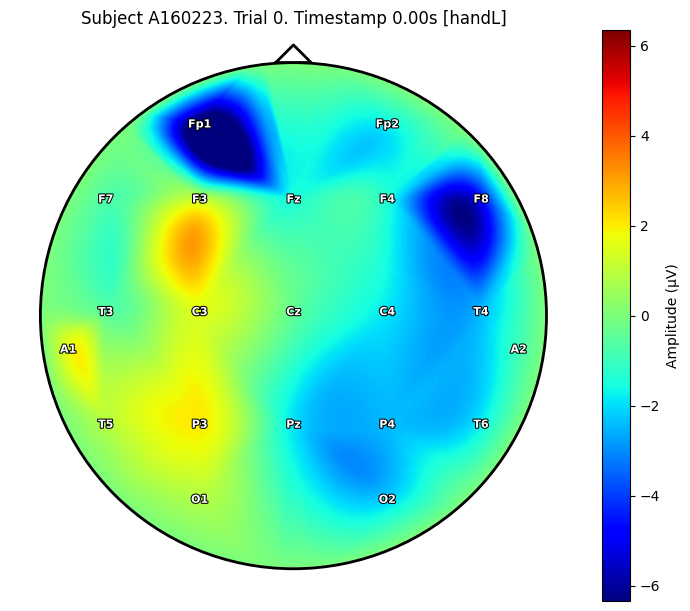

In [20]:
ds4_subject.plot_head(trial=0, plot_joint=False)

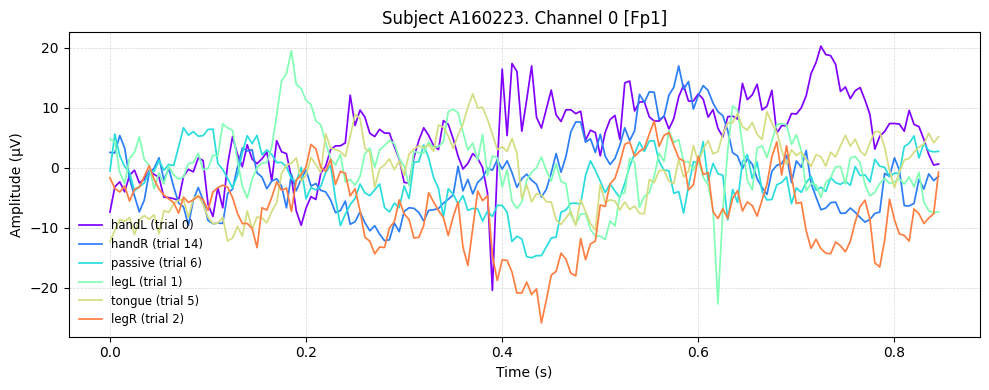

In [18]:
ds4_subject.plot_channel(trial=0, channel=0)

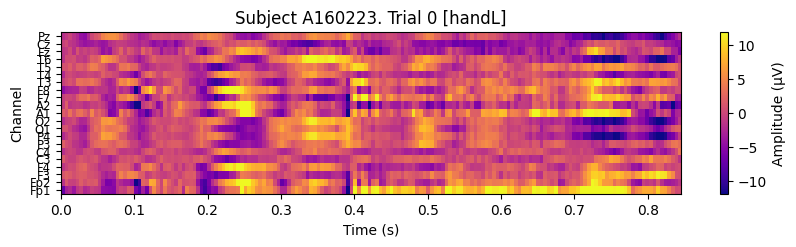

In [19]:
ds4_subject.plot_trial_heatmap(trial=0)

# Datset 8: High-Gamma Dataset
128-electrode dataset obtained from 14 healthy subjects with roughly 1000 four-second trials of executed movements divided into 13 runs per subject. The four classes of movements were movements of either the left hand, the right hand, both feet, and rest.

### DS8 File Contents

### DS8 Data Examples

## Classification

In [11]:
X, Y, groups = ds1.get_XY()
X.shape, Y.shape, groups.shape

((10120, 64, 1024), (10120,), (10120,))

In [21]:
X, Y, groups = ds4.get_XY()
X.shape, Y.shape, groups.shape

((4790, 21, 170), (4790,), (4790,))

### DS1 Baseline

In [ ]:
scores = ds1_baseline.evaluate_all_subjects(X, Y, groups, n_repeats=120, seed=42)

s01: 81.17% ± 4.10%
s02: 49.14% ± 6.04%
s03: 92.99% ± 2.39%
s04: 86.39% ± 3.27%
s05: 76.83% ± 5.13%
s06: 82.65% ± 4.01%
s07: 48.56% ± 6.08%
s08: 48.92% ± 6.74%
s09: 71.23% ± 4.30%
s10: 75.32% ± 7.74%
s11: 59.28% ± 7.72%
s12: 68.24% ± 4.70%
s13: 62.06% ± 7.20%
s14: 97.43% ± 1.85%
s15: 76.74% ± 4.19%
s16: 53.46% ± 5.45%
s17: 47.68% ± 5.37%
s18: 59.00% ± 6.55%
s19: 58.99% ± 5.08%
s20: 67.58% ± 8.35%
s21: 71.04% ± 5.39%
s22: 58.31% ± 5.97%
s23: 85.24% ± 4.26%
s24: 65.40% ± 5.37%
s25: 67.87% ± 6.48%
s26: 65.71% ± 6.99%
s27: 57.88% ± 5.06%
s28: 60.32% ± 5.84%
s30: 61.22% ± 7.37%
s31: 65.06% ± 7.18%
s32: 53.24% ± 5.74%
s33: 63.44% ± 4.66%
s35: 78.75% ± 3.84%
s36: 68.61% ± 9.01%
s37: 62.35% ± 6.32%
s38: 51.47% ± 5.49%
s39: 63.00% ± 5.44%
s40: 50.44% ± 7.58%
s41: 88.42% ± 3.53%
s42: 58.68% ± 5.40%
s43: 96.07% ± 3.56%
s44: 68.51% ± 5.03%
s45: 54.94% ± 6.12%
s46: 79.07% ± 4.42%
s47: 64.93% ± 5.92%
s48: 80.51% ± 9.63%
s49: 74.92% ± 3.84%
s50: 83.57% ± 4.86%
s51: 53.04% ± 5.14%
s52: 69.97% ± 6.65%
